# Обработка датасета русского рэпа

Скачав архив с собранными json - файлами, несущих информацию о треках, первым делом пришлось приводить в читабельный вид. Так как кодировка и у названий файлов и их содержимого была maccyrillic. И всю кириллицу ни средства маздая, ни pycharm не могли воспроизвести.

![title](screens/1.PNG)

После осмотра контента было замечено, что многие артисты повторяются в силу разного написания их имени (например "1kla$", "1 kla$", "1кла$", несколько вариантов витикаки47 и т.п.). Таким образом, необходимо найти все треки, что принадлежат одному исполнителю. 

Плюсом ко всему этому имеет место быть совместные записи нескольких исполнителей. Присвоить трек первому как-то неправильно, а учитывать их как отдельный коллектив в общей картине будет как-то странно (в большинстве случаев у них всего один трек). Поэтому отбрасываем все треки, что имеют в имени исполнителя feat. или где через запятую перечислены рэперы.

Чтоб достигнуть поставленной цели, приводим имя исполнителя к "некоторому каноничному виду". Все буквы - мелкие, пробелы убираем, транслитерацией переводим имя в русские буквы, и после всего этого ещё находим расстояние Левенштейна между словами и если оно меньше 3-х, то будем принимать исполнителя за одного.

Все необходимое для функций, что потребуются еще много раз:

In [2]:
import string
import json
import os
from glob import glob
import re
from transliterate import translit
import urllib.parse

FLAG_ABOUT_REPEAT = 'hvjkbvjkjkbjkerk'

patternFeat = re.compile(".* ?feat ?.*")
patternFeat2 = re.compile(".+[,&] ?.+")
artists = set()

In [3]:
def levenshtein(s1, s2):
    if len(s1) < len(s2):
        return levenshtein(s2, s1)
    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    return previous_row[-1]

In [4]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [5]:
def normilizeArtist(str):
    return translit(re.sub('\(.*\)', '', str).lower().replace(' ', ''), "ru")

Функция, которая в указанной папке среди треков будет искать уникальных исполнителей:

In [6]:
def findUniqueName(dirpath):
    for path in glob(os.path.join(os.path.expanduser(dirpath), '*.json')):
        file = open(path, mode="r", encoding="maccyrillic")
        data = json.load(file)
        artist = urllib.parse.unquote(data["artist"]).encode('maccyrillic').decode('utf-8')
        if not (bool(patternFeat.match(artist)) or bool(patternFeat2.match(artist))):
            artists.add(artist)

    artList = list(sorted(artists))

    for i in range(0, len(artList) - 1):
        for j in range(i + 1, len(artList)):
            if levenshtein(normilizeArtist(artList[i]), normilizeArtist(artList[j])) < 3:
                artList[j] = FLAG_ABOUT_REPEAT

    return list(set(artList) - set([FLAG_ABOUT_REPEAT]))

Перечень всех имеющихся:

In [9]:
print(sorted(findUniqueName("./songs")))

['!ShAdow!', '$APER', '1 Kla$', '1000 y.e.', '1000 Слов', '13FRONT', '228', '2H Company', '3NT', "4'K", '43 Градуса', '4пыль', '5 Плюх', '56 размер', '6-ой отряд и Главные Герои', '63 Регион', '9 Грамм', 'AK-47', 'AL Hammer', 'Ahimas', 'Al Solo', 'AlexJackpot', 'Amlaut', 'Anacondaz', 'Ar-SiDE', 'Axxy', 'AzonE', 'Aztecs', 'B-Laba', 'B-Noble', 'B.b. [TERRA INCOGNITA]', 'Babangida', 'Bad Game', 'Bahh Tee', 'Basic', 'Beat Of Life', 'Beny Krik', 'Bess', 'Big Black Boots', 'BrainDraiN', 'Buhar Jerreau', 'C-Pack', 'C4', 'CENTR', 'Check', 'Chooze', 'Counter Attack', 'CуиСайд', "D'ARTY", 'D-MAN 55', 'D.A.P.A.', 'D.L.S', 'D.Masta', 'D1MASS', 'DANDY', 'DIUv[Kadastra_pro]', 'DOm1no (FreshTime)', 'DRedd', 'Da 108', 'Da B.O.M.B.', 'Da Gudda Jazz', 'Da Gudda Prod.', 'Da St', 'De F. (Дефицит)', 'De Facto', 'DeShawn a.k.a. Je', 'Dead Poets', 'Dessar', 'Dime', 'Dinastia S. L.', 'Dino MC 47', 'Djang', 'DoN-A', 'Dobermann', 'Dogma KZ', 'DotsFam', 'Double Magnum', 'DragN', 'Dza-Dze', 'Dzham', "DИ'АСПОРА", 

Дальше необходимо провести препроцессинг текстов:

In [7]:
from nltk import SnowballStemmer
from nltk.corpus import stopwords

def text_stemming(raw_text, wordDict = None):
  clean_text = []
  raw_text=raw_text.replace('\t', ' ').replace('\n', ' ').replace('\r', '').replace('–', '')
    
  for punctuation in string.punctuation:
    raw_text = raw_text.replace(punctuation, ' ')
    
  raw_text = raw_text.split()
  stemmer = SnowballStemmer("russian")
  for word in raw_text:
    word_low = word.lower()
    if word_low not in stopwords.words('russian') and not word.isdigit():
        if wordDict is not None:
            if word_low in wordDict:
                clean_text.append(stemmer.stem(word_low))
        else:
            clean_text.append(stemmer.stem(word_low))

  clean_text = ' '.join(clean_text)
  return clean_text

Т.к. вновь будем пробегать по json файлам, где указаны первоначальные имена, то для определения к какому исполнителю относится песня, используем данную функцию:

In [8]:
def findArtistsKey(str):
    for item in docCollection.keys():
        if un.levenshtein(un.normilizeArtist(str), un.normilizeArtist(item)) < 3:
            return item
    return None

Подготавливаем словарь для текстов

In [14]:
DIR_PATH = ".\\songs"
docCollection = dict()
for item in findUniqueName(DIR_PATH):
    docCollection[item] = list()
docCollection

{'Eighty Eight': [],
 'Шахматист': [],
 'ХОРОрШОу': [],
 'Интервенция': [],
 'Убитые рэпом': [],
 'Da Gudda Prod.': [],
 'Slow Flow': [],
 'Dobermann': [],
 'Ганза': [],
 'Макс Винтер': [],
 'Крип-А-Крип (Крипл)': [],
 'DotsFam': [],
 'Паша Морган': [],
 'Чаян Famaly': [],
 'Театр Теней': [],
 'Риару': [],
 'Дядя Женя': [],
 'Фаддей': [],
 'Hann': [],
 'Ahimas': [],
 'Бурый': [],
 'KimBusta': [],
 'Плохие Белые': [],
 'The ЛП (Ленина Пакет)': [],
 'MC 1.8': [],
 'D-MAN 55': [],
 'DragN': [],
 'Beat Of Life': [],
 'Bess': [],
 'MaryJane': [],
 'T-killah': [],
 '56 размер': [],
 'Lenin': [],
 'Kurbat': [],
 'Miss Fenix': [],
 'EK-Playaz': [],
 'Dinastia S. L.': [],
 "Lil'M": [],
 'Raphael': [],
 'Mr. Hyde': [],
 'Капа и Картель': [],
 'Aztecs': [],
 'Little B.': [],
 'Da St': [],
 'Kore': [],
 'DoN-A': [],
 'Dzham': [],
 'Franky Freak': [],
 'LegMc': [],
 '228': [],
 'Витяй Счастье': [],
 'MC Den': [],
 "N'Pans": [],
 'Kozz Porno': [],
 'T1One a.k.a. Коля Сканк': [],
 'Kiraz': [],
 'Ниль

Заполняем структуру текстами и сохраняем в папку "textsByArtist" json файлы с предобработанными текстами исполнителей

In [ ]:
for path in glob(os.path.join(os.path.expanduser(DIR_PATH), '*.json')):
    file = open(path, mode="r", encoding="maccyrillic")
    data = json.load(file)
    artist = un.normilizeArtist(urllib.parse.unquote(data["artist"]).encode('maccyrillic').decode('utf-8'))

    keyArtist = findArtistsKey(artist)
    if keyArtist is not None:
        text = text_stemming(urllib.parse.unquote(' '.join(data['text'])).encode('maccyrillic').decode('utf-8', errors="ignore"))
        docCollection[keyArtist].append(text)

for key in docCollection.keys():
    with open('.\\textsByArtist\\' + key.replace(' ', '_') + '.json', 'w', encoding='utf-8') as outfile:
        json.dump({"artist": key, "texts": docCollection[key]}, outfile, ensure_ascii=False)

Итого 444 исполнителя

![title](screens/2.PNG)

Дальше необходимо для кажого исполнителя найти ТОП 1000 используемых слов.
Реализовываем типовую задачу на MapReduce:

In [ ]:
import sys
from mrjob.job import MRJob
from mrjob.protocol import ReprProtocol
import operator
import re

WORD_RE = re.compile(r"[A-Za-zА-Яа-я]+")

class MRWordFreqCount(MRJob):
    OUTPUT_PROTOCOL = ReprProtocol

    def mapper(self, _, line):
        for word in WORD_RE.findall(line):
            yield word.lower(), 1

    def combiner(self, word, counts):
        yield word, sum(counts)

    def reducer(self, word, counts):
        yield word, str(sum(counts))

if __name__ == '__main__':
    worker = MRWordFreqCount()
    worker.sandbox(open(sys.argv[1], 'rb'))

    result = dict()

    with worker.make_runner() as runner:
        runner.run()
        for key, value in worker.parse_output(runner.cat_output()):
            if len(key) > 2:
                result[key] = int(value)

        result.pop('artist', None)
        result.pop('texts', None)
        countRows = 0
        with open(sys.argv[2], 'w') as f:
            for item in sorted(result.items(), key=operator.itemgetter(1), reverse=True):
                if countRows < 1000:
                    f.write(item[0] + " " + str(item[1]) + "\n")
                    countRows += 1

А дальше, запускаем .bat - файл со следующим содержанием:

In [ ]:
if not exist ".\sortWordFreq" mkdir .\sortWordFreq
for %%f in (.\textsByArtist\*) do python freq_words.py %%f .\sortWordFreq\%%~nf

В итоге получим папку .\sortWordFreq с топ-1000 для каждого исполнителя

![title](screens/3.PNG)

Теперь имея данные, визуализируем как близко друг к другу находятся исполнители относительно исполняемого контента

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.manifold import MDS

MDS()

DIR_PATH_TEXTS = ".\\textsByArtist"
DIR_PATH_WORDS = ".\\sortWordFreq"

textArtist = dict()


def getWordSet(filename):
    result = set()
    file = open(DIR_PATH_WORDS + "\\" + filename)
    for line in file:
        result.add(line.split(" ")[0])
    return result

In [10]:
for path in glob(os.path.join(os.path.expanduser(DIR_PATH_TEXTS), '*.json')):
    nameFile = os.path.basename(path)[:os.path.basename(path).rfind('.')]  # without extension
    file = open(path, mode="r", encoding="maccyrillic")
    data = json.load(file)
    artist = urllib.parse.unquote(data["artist"]).encode('maccyrillic').decode('utf-8')
    wordSet = getWordSet(nameFile)

    texts = list()
    for text in data['texts']:
        texts.append(text_stemming(urllib.parse.unquote(text).encode('maccyrillic').decode('utf-8', errors="ignore"),
                                   wordDict=wordSet))
    textArtist[artist] = " ".join(texts)

listArt = np.array(list(textArtist.items()))
print(listArt)

tfidf_vectorizer = TfidfVectorizer(max_df=0.9, max_features=200000,
                                   min_df=0.1,
                                   use_idf=True, ngram_range=(1, 1))

tfidf_matrix = tfidf_vectorizer.fit_transform(listArt[:, 1])
print(tfidf_matrix.shape)

terms = tfidf_vectorizer.get_feature_names()
print(terms)
dist = 1 - cosine_similarity(tfidf_matrix)
dist.shape

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



(444, 1372)
['авт', 'адрес', 'азарт', 'алкогол', 'алл', 'альб', 'ангел', 'андеграунд', 'арм', 'асфальт', 'атак', 'баб', 'бабк', 'бабл', 'базар', 'бакс', 'бал', 'балкон', 'банальн', 'банд', 'банк', 'бар', 'барыг', 'бас', 'баттл', 'башк', 'башн', 'бег', 'бегут', 'бед', 'беж', 'бездн', 'безумн', 'бел', 'бер', 'берег', 'берет', 'бес', 'бесконечн', 'бесполезн', 'бетон', 'беш', 'бизнес', 'бил', 'билет', 'бит', 'битв', 'благ', 'благодар', 'блеск', 'ближ', 'близк', 'блин', 'блокнот', 'бля', 'бляд', 'блят', 'бо', 'бог', 'богат', 'бож', 'бок', 'бол', 'болезн', 'болт', 'больн', 'больш', 'бомб', 'борт', 'борьб', 'босс', 'брал', 'брат', 'братв', 'братк', 'бред', 'бро', 'брод', 'брос', 'брош', 'буд', 'будеш', 'будн', 'будут', 'будущ', 'букв', 'бумаг', 'бур', 'бутылк', 'бух', 'быв', 'бык', 'быстр', 'быт', 'бьет', 'бьют', 'вагон', 'важн', 'вал', 'ван', 'вар', 'вариант', 'ват', 'ваш', 'вверх', 'вдал', 'вдво', 'вдох', 'вдых', 'вед', 'ведет', 'ведут', 'везд', 'век', 'вел', 'велик', 'вен', 'вер', 'верн', 

(444, 444)

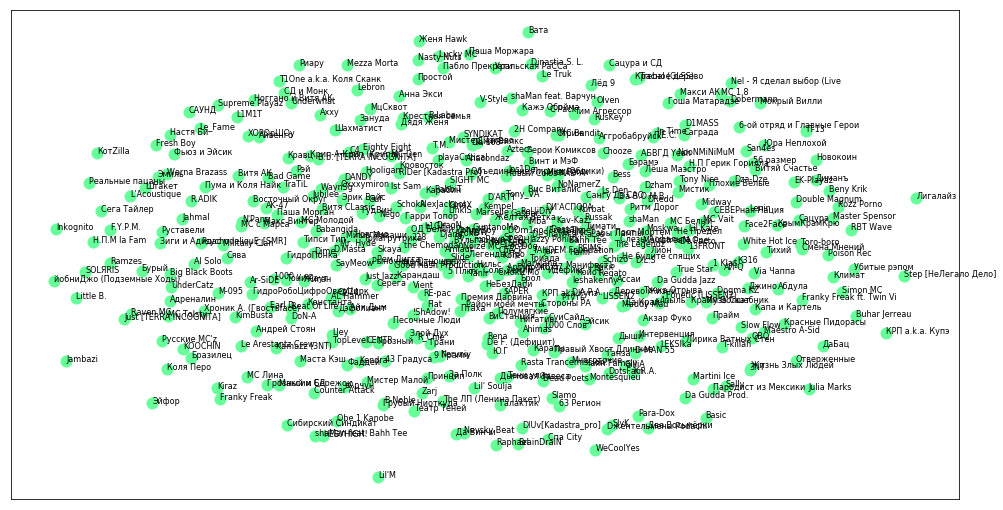

In [11]:
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
xs, ys = pos[:, 0], pos[:, 1]

df = pd.DataFrame(dict(x=xs, y=ys, name=listArt[:, 0]))

df.to_csv("results.csv", sep='\t', encoding='utf-8')

fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05)

for index, row in df.iterrows():
    ax.plot(row['x'], row['y'], marker='o', linestyle='', ms=12, color='#66ff99', mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
    ax.tick_params(axis='y', which='both', left='off', top='off', labelleft='off')

for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['name'], size=8)

plt.show()

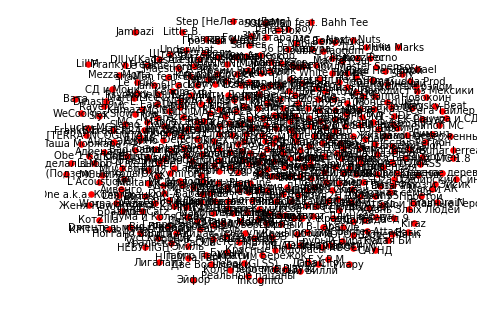

In [13]:
import networkx as nx
G = nx.Graph()

for i in range(len(dist)):
    for j in range(i + 1, len(dist)):
        G.add_edge(listArt[i, 0], listArt[j, 0], weight=dist[i][j])

nx.drawing.nx_pylab.draw_kamada_kawai(G, with_labels=True, edge_color="#FFFFFF", node_size=30, font_size=10)

БОООЛЬ((( как не пыталась нагуглить, как бы это подрастянуть - не нашла((((

Теперь проведем LDA-анализ для всего корпуса русского рэпа. Для этого все тексты смержим в один файл.

In [ ]:
texts = list()
DIR_PATH_TEXTS = ".\\songs"

countTexts = 0

for path in glob(os.path.join(os.path.expanduser(DIR_PATH_TEXTS), '*.json')):
    file = open(path, mode="r", encoding="maccyrillic")
    data = json.load(file)
    text = text_stemming(
        urllib.parse.unquote(' '.join(data['text'])).encode('maccyrillic').decode('utf-8', errors="ignore"))
    texts.append(text.split())
    countTexts += 1
    if countTexts % 1 == 0:
        print("Complete: " + str(countTexts))

with open('for_lda.json', 'w', encoding='utf-8') as filehandle:
    json.dump(texts, filehandle, ensure_ascii=False)

![title](screens/4.PNG)

In [7]:
import json
from gensim import corpora, models, similarities

with open('for_lda.json', 'r', encoding='utf-8') as file:
    texts = json.load(file)

dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=1, no_above=0.7)
corpus = [dictionary.doc2bow(text) for text in texts]

lda = models.LdaModel(corpus, num_topics=10,
                      id2word=dictionary,
                      update_every=5,
                      chunksize=5000,
                      passes=100)

lda.show_topics()

topics_matrix = lda.show_topics(formatted=False, num_words=20)
print("Topics:")
for item in topics_matrix:
    print(item)

После полутора часов вычислений, получила следующие результаты:

In [ ]:
Topics:
(0,
 [('жизн', 0.007569376), ('сво', 0.006806156), ('мир', 0.0060578203), ('люд', 0.0059849625), ('вер', 0.0058179046),
  ('наш', 0.0042834077), ('кажд', 0.004246467), ('пок', 0.0038917342), ('все', 0.00387356), ('сил', 0.003390165),
  ('бог', 0.0033693174), ('нам', 0.0031815032), ('стал', 0.0031753213), ('свет', 0.0031492333),
  ('брат', 0.0029872076), ('пут', 0.0029515475), ('рук', 0.0028291084), ('одн', 0.0028127462),
  ('глаз', 0.002788241), ('душ', 0.0027598834)])
(1, [('че', 0.016046572), ('i', 0.010510571), ('yo', 0.0078255255), ('the', 0.006536205), ('a', 0.0061505055),
     ('on', 0.0049407114), ('дава', 0.004653976), ('э', 0.0043100915), ('my', 0.004097153), ('me', 0.004057307),
     ('it', 0.0038767348), ('and', 0.0036471877), ('говор', 0.0036002144), ('to', 0.003565932), ('s', 0.0034318552),
     ('m', 0.0033739947), ('ху', 0.0031222678), ('is', 0.0029849822), ('in', 0.0027481962), ('ид', 0.0027099175)])
(2, [('тво', 0.012271334), ('все', 0.010460019), ('прост', 0.010247782), ('мо', 0.009249248), ('теб', 0.0075250743),
     ('глаз', 0.0062158415), ('тоб', 0.005926064), ('буд', 0.0058406373), ('зна', 0.005617251),
     ('одн', 0.0055989777), ('сво', 0.0055766203), ('жизн', 0.0053042867), ('сердц', 0.0051787044),
     ('друг', 0.0051345457), ('лиш', 0.0047756704), ('люб', 0.0046680206), ('ноч', 0.0046352306),
     ('слов', 0.004559042), ('нам', 0.0045412625), ('любов', 0.0043149334)])
(3, [('мо', 0.009818013), ('рэп', 0.00849791), ('все', 0.008285733), ('слов', 0.0046530548), ('пок', 0.004291819),
     ('нам', 0.004188155), ('прост', 0.0040306947), ('ещ', 0.0038254077), ('сво', 0.003768059),
     ('буд', 0.003716336), ('жизн', 0.0037093356), ('песн', 0.0034829006), ('наш', 0.0032918511),
     ('кажд', 0.003175574), ('так', 0.0031666828), ('ваш', 0.0030745266), ('музык', 0.0030394709),
     ('люд', 0.00282136), ('перв', 0.0027565693), ('сам', 0.002753199)])
(4,
 [('дела', 0.012998416), ('наш', 0.00737576), ('сво', 0.0062531857), ('кажд', 0.005656418), ('дава', 0.005136786),
  ('нам', 0.0050817993), ('двига', 0.004902778), ('всем', 0.004784577), ('танц', 0.004295346), ('бит', 0.004224436),
  ('кача', 0.0038990478), ('ак', 0.003734639), ('э', 0.003411792), ('рэп', 0.0033284705), ('ваш', 0.0030877197),
  ('пок', 0.0030299681), ('голов', 0.0028115255), ('тем', 0.0026174474), ('клуб', 0.0025396813),
  ('выш', 0.0025314004)])
(5, [('волн', 0.0066411295), ('им', 0.005699862), ('город', 0.00547547), ('привет', 0.004935737),
     ('паца', 0.004689538), ('ввид', 0.0045570075), ('наш', 0.0044905776), ('ак', 0.003984469),
     ('дом', 0.0032997057), ('мод', 0.0032075294), ('ро', 0.0031478025), ('стенк', 0.0031333484),
     ('ват', 0.0023620524), ('трит', 0.0023339055), ('лял', 0.0021042507), ('поня', 0.0019580326),
     ('солнц', 0.0019026482), ('куб', 0.0017816088), ('чемода', 0.0017237044), ('шаг', 0.0016819149)])
(6,
 [('хоп', 0.010514767), ('хип', 0.010282907), ('рэп', 0.0057334406), ('любл', 0.005031193), ('люб', 0.0046099564),
  ('город', 0.0036879058), ('ногга', 0.0031546715), ('клуб', 0.0029306023), ('бит', 0.0028293012),
  ('москв', 0.0028071855), ('крут', 0.0027908785), ('крич', 0.0027231604), ('тво', 0.0025644551),
  ('наш', 0.0025466473), ('дава', 0.0025267547), ('стил', 0.002500509), ('go', 0.002491202), ('сам', 0.0023811597),
  ('ваш', 0.0023307311), ('мно', 0.0020927743)])
(7, [('дом', 0.0063220104), ('мо', 0.00594932), ('так', 0.004535566), ('че', 0.0044897), ('нам', 0.0043744356),
     ('район', 0.004060315), ('дел', 0.0037398015), ('пар', 0.003549353), ('кур', 0.0033047262),
     ('дава', 0.0032642994), ('сво', 0.002909181), ('утр', 0.0029073337), ('все', 0.0028744193),
     ('мам', 0.0028477663), ('паца', 0.002793178), ('помн', 0.0027703983), ('москв', 0.0027305789),
     ('наш', 0.0026055158), ('рук', 0.0024227584), ('одн', 0.0024190333)])
(8,
 [('тво', 0.01692999), ('теб', 0.009351816), ('рэп', 0.007350007), ('баттл', 0.0045784838), ('пар', 0.0039088624),
  ('сук', 0.0038567258), ('трек', 0.003719616), ('ваш', 0.0032790354), ('буд', 0.0031615451),
  ('парен', 0.0030902743), ('прост', 0.0029534495), ('е', 0.0028721197), ('мо', 0.002848247), ('сво', 0.0027473432),
  ('нужн', 0.002636237), ('дела', 0.0024973573), ('перв', 0.0024064395), ('так', 0.0023552983),
  ('пок', 0.0023094139), ('раунд', 0.0022668224)])
(9, [('рэп', 0.0161417), ('тво', 0.015193637), ('сво', 0.0081357425), ('мо', 0.0064990795), ('ваш', 0.0051548895),
     ('сук', 0.00505446), ('теб', 0.0050508855), ('люб', 0.004474324), ('говор', 0.004439613),
     ('прост', 0.003975548), ('ху', 0.003695244), ('нах', 0.0035016106), ('чита', 0.003495981),
     ('дела', 0.0034210547), ('пох', 0.0034104201), ('русск', 0.003341228), ('зна', 0.0033246563),
     ('так', 0.0033209021), ('че', 0.0032139292), ('всем', 0.0031731024)])

#### Попробуем пересобрать LDA, но на этот раз корпус будет предобработан с помощью pymorphy2

In [ ]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

texts = list()
DIR_PATH_TEXTS = ".\\songs"

countTexts = 0

def text_lemmat(raw_text):

  clean_text = []

  raw_text=raw_text.replace('\t', ' ').replace('\n', ' ').replace('\r', '').replace('–', '')
  for punctuation in string.punctuation:
    raw_text = raw_text.replace(punctuation, ' ')
  raw_text = raw_text.split()

  for word in raw_text:
    word_low = word.lower()
    if word_low not in stopwords.words('russian') and not word.isdigit():
        clean_text.append(morph.parse(word_low)[0].normal_form)

  clean_text = ' '.join(clean_text)
  return clean_text

for path in glob(os.path.join(os.path.expanduser(DIR_PATH_TEXTS), '*.json')):
    file = open(path, mode="r", encoding="maccyrillic")
    data = json.load(file)
    text = text_lemmat(
        urllib.parse.unquote(' '.join(data['text'])).encode('maccyrillic').decode('utf-8', errors="ignore"))
    texts.append(text.split())
    countTexts += 1
    if countTexts % 100 == 0:
        print("Complete: " + str(countTexts))

with open('for_lda_pymorphy2.json', 'w', encoding='utf-8') as filehandle:
    json.dump(texts, filehandle, ensure_ascii=False)

![title](screens/5.PNG)

Повторяем проделанные ранее действия:

In [ ]:
with open('for_lda_pymorphy2.json', 'r', encoding='utf-8') as file:
    texts = json.load(file)

dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=1, no_above=0.7)
corpus = [dictionary.doc2bow(text) for text in texts]

lda = models.LdaModel(corpus, num_topics=10,
                      id2word=dictionary,
                      update_every=5,
                      chunksize=5000,
                      passes=100)
lda.show_topics()
lda.save('lda_pymorphy2.model')

topics_matrix = lda.show_topics(formatted=False, num_words=20)
print("Topics:")
for item in topics_matrix:
    print(item)

Резульатыты следующие:

In [10]:
Topics:
(0, [('дым', 0.008040588), ('наш', 0.004300883), ('злой', 0.0028625159), ('рука', 0.0027046825), ('дать', 0.0025401495), ('пока', 0.0025305978), ('игра', 0.0024065967), ('рэп', 0.0023944115), ('битый', 0.002381483), ('go', 0.0021224583), ('сидеть', 0.0020569349), ('город', 0.0020124156), ('ум', 0.0019346322), ('слово', 0.0018032762), ('я', 0.0017695323), ('нога', 0.0017081), ('один', 0.0017050557), ('звезда', 0.0016519522), ('тони', 0.0015985807), ('вокруг', 0.0015900517)])
(1, [('город', 0.005743424), ('наш', 0.004886588), ('весь', 0.0048688683), ('свой', 0.0037141286), ('рэп', 0.002959832), ('мир', 0.0029477025), ('мы', 0.0027434702), ('ваш', 0.002702564), ('каждый', 0.0026603895), ('новый', 0.0025305292), ('ещё', 0.0024280145), ('стиль', 0.0022813666), ('тот', 0.0021832718), ('хип', 0.002154288), ('рука', 0.0021147688), ('место', 0.0021049038), ('хоп', 0.0020902639), ('пока', 0.0019864198), ('самый', 0.0019608464), ('хуй', 0.0019289247)])
(2, [('иметь', 0.005592974), ('наш', 0.0048232125), ('ввиду', 0.004211554), ('пам', 0.0036454727), ('пара', 0.0035975613), ('е', 0.003312414), ('оу', 0.0028129134), ('соня', 0.0026658417), ('продолжать', 0.0025221026), ('свой', 0.002501949), ('ау', 0.0023730625), ('никто', 0.0022867967), ('мой', 0.001873824), ('делать', 0.0018380746), ('двигать', 0.0018178495), ('рыжий', 0.0017875588), ('жить', 0.0016264165), ('давать', 0.0016118942), ('путь', 0.0015722254), ('стоять', 0.0015451204)])
(3, [('весь', 0.010390155), ('ты', 0.009733516), ('твой', 0.009406942), ('мой', 0.0081019355), ('один', 0.00686717), ('знать', 0.0059006168), ('быть', 0.005806712), ('глаз', 0.0056293164), ('свой', 0.0054395334), ('просто', 0.0053968676), ('жизнь', 0.0052580703), ('день', 0.0050612073), ('время', 0.0048799594), ('хотеть', 0.00478417), ('мир', 0.004766569), ('тот', 0.004749181), ('любовь', 0.0047059916), ('небо', 0.0045387554), ('сердце', 0.0043530944), ('мы', 0.0043345504)])
(4, [('—', 0.014862558), ('эй', 0.010142327), ('любить', 0.007874739), ('грязь', 0.0046048327), ('ноггано', 0.00427272), ('рука', 0.003943183), ('слышать', 0.0031017505), ('пом', 0.0029561825), ('зал', 0.0029136345), ('ди', 0.0028089862), ('понять', 0.0024997515), ('должный', 0.0024001186), ('заткнуться', 0.002220201), ('ощутить', 0.0020541542), ('кутуз', 0.0020397282), ('погнать', 0.0020069876), ('куб', 0.0019740998), ('наркотик', 0.0018954182), ('проклятый', 0.0018909929), ('вибрация', 0.001883225)])
(5, [('i', 0.013990224), ('you', 0.010467823), ('a', 0.0094817085), ('ак', 0.009156804), ('the', 0.008275206), ('ла', 0.005403087), ('it', 0.005356414), ('my', 0.005197965), ('me', 0.0050998526), ('m', 0.005015557), ('s', 0.0049861763), ('and', 0.0046274285), ('to', 0.004272254), ('is', 0.00390435), ('витя', 0.0038195977), ('on', 0.003705931), ('don', 0.0036588842), ('чё', 0.0036065113), ('t', 0.0033932168), ('стиль', 0.0033660165)])
(6, [('весь', 0.01492256), ('человек', 0.01147631), ('жизнь', 0.010023405), ('свой', 0.009120153), ('знать', 0.007921699), ('тот', 0.0076941727), ('каждый', 0.0057857344), ('жить', 0.00571937), ('хотеть', 0.005370407), ('мой', 0.0053616096), ('наш', 0.0053292136), ('стать', 0.0053021866), ('верить', 0.005247878), ('деньга', 0.005040776), ('видеть', 0.0048222137), ('быть', 0.0044583105), ('бог', 0.004373515), ('мир', 0.0041864766), ('делать', 0.0040609986), ('такой', 0.0039202822)])
(7, [('ты', 0.014949786), ('хотеть', 0.008349294), ('твой', 0.0076499265), ('делать', 0.0072781616), ('любить', 0.0072620884), ('её', 0.006038281), ('такой', 0.0056387666), ('секс', 0.0049334927), ('девочка', 0.0046288343), ('детка', 0.004576624), ('клуб', 0.0045340075), ('милый', 0.00407936), ('просто', 0.0039993073), ('танцевать', 0.003944722), ('любовь', 0.0039055885), ('эй', 0.003780719), ('мы', 0.003777811), ('быть', 0.0037687293), ('друг', 0.003472763), ('один', 0.0032800203)])
(8, [('рэп', 0.017638875), ('твой', 0.016830921), ('ты', 0.007792209), ('мой', 0.0069034006), ('весь', 0.0065035434), ('ваш', 0.0061230245), ('свой', 0.005955002), ('хотеть', 0.005520118), ('быть', 0.0054876534), ('трек', 0.0048711547), ('делать', 0.0041873353), ('знать', 0.004163761), ('хип', 0.004150117), ('просто', 0.004124902), ('хоп', 0.004037263), ('читать', 0.00373443), ('слово', 0.003590964), ('дать', 0.0035215488), ('пока', 0.003469197), ('парень', 0.0034242426)])
(9, [('весь', 0.00880593), ('че', 0.0050386568), ('дом', 0.004658386), ('пацан', 0.0044206157), ('давать', 0.004099592), ('район', 0.0039157798), ('такой', 0.0034785138), ('мы', 0.0034441215), ('курить', 0.0033048561), ('дело', 0.0032217018), ('свой', 0.0031054777), ('наш', 0.0030471215), ('быть', 0.0029866216), ('тот', 0.0028908995), ('москва', 0.0028771919), ('один', 0.002846709), ('чё', 0.0026745435), ('пока', 0.0026068895), ('делать', 0.0025612828), ('идти', 0.002280078)])


In [18]:
# with open('for_lda_pymorphy2.json', 'r', encoding='utf-8') as file:
#     texts = json.load(file)

# dictionary = corpora.Dictionary(texts)
# dictionary.filter_extremes(no_below=1, no_above=0.7)
# corpus = [dictionary.doc2bow(text) for text in texts]

import pyLDAvis.gensim
pyLDAvis.enable_notebook()
lda =  models.LdaModel.load('lda_pymorphy2.model')
pyLDAvis.gensim.prepare(lda, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.192379 -0.000191       1        1  44.698128
8      0.120562  0.051659       2        1  13.761814
6      0.157533 -0.003337       3        1  13.489930
9      0.103629  0.008608       4        1  12.751678
1      0.026239 -0.015960       5        1   5.612933
7      0.010705  0.006293       6        1   2.678714
0     -0.038822 -0.054659       7        1   2.574247
5     -0.212126  0.229565       8        1   2.248583
2     -0.152794 -0.103627       9        1   1.279747
4     -0.207306 -0.118351      10        1   0.904229, topic_info=      Category          Freq         Term         Total  loglift  logprob
term                                                                     
357    Default   9209.000000           ты   9209.000000  30.0000  30.0000
235    Default  10398.000000         твой  10398.000000  29.0000  29.0000
65     Default   3667.000000       любить   3667.000000  28.0000  28.0000
795    Default   4248.000000          рэп   4248.000000  27.0000  27.0000
158    Default   6048.000000       хотеть   6048.000000  26.0000  26.0000
206    Default   5375.000000          наш   5375.000000  25.0000  25.0000
632    Default   3333.000000       любовь   3333.000000  24.0000  24.0000
162    Default   4917.000000      человек   4917.000000  23.0000  23.0000
190    Default   3217.000000       делать   3217.000000  22.0000  22.0000
616    Default   5861.000000        жизнь   5861.000000  21.0000  21.0000
1092   Default   1656.000000           её   1656.000000  20.0000  20.0000
2263   Default   1435.000000          дым   1435.000000  19.0000  19.0000
1066   Default   3919.000000         рука   3919.000000  18.0000  18.0000
17     Default  13174.000000         весь  13174.000000  17.0000  17.0000
365    Default    972.000000           эй    972.000000  16.0000  16.0000
676    Default   3531.000000        такой   3531.000000  15.0000  15.0000
266    Default   2978.000000        город   2978.000000  14.0000  14.0000
121    Default   7618.000000         свой   7618.000000  13.0000  13.0000
324    Default   5311.000000       просто   5311.000000  12.0000  12.0000
124    Default   1919.000000      слышать   1919.000000  11.0000  11.0000
86     Default   1865.000000         пара   1865.000000  10.0000  10.0000
254    Default   2800.000000       верить   2800.000000   9.0000   9.0000
35     Default   3290.000000         жить   3290.000000   8.0000   8.0000
67     Default   4316.000000          мир   4316.000000   7.0000   7.0000
1593   Default   2197.000000         ночь   2197.000000   6.0000   6.0000
655    Default   2842.000000       понять   2842.000000   5.0000   5.0000
720    Default   1887.000000        никто   1887.000000   4.0000   4.0000
2877   Default    753.000000        иметь    753.000000   3.0000   3.0000
1485   Default    461.000000            i    461.000000   2.0000   2.0000
427    Default   5059.000000           мы   5059.000000   1.0000   1.0000
...        ...           ...          ...           ...      ...      ...
20008  Topic10     16.432747        жарка     26.625191   4.2233  -6.6856
17754  Topic10     56.228176      ноггано    155.537994   3.6884  -5.4555
2764   Topic10     24.782881     вибрация     60.178215   3.8187  -6.2748
51969  Topic10      6.310444  артемовский      8.940300   4.3575  -7.6427
3718   Topic10     29.217421   заткнуться     83.891029   3.6511  -6.1102
19472  Topic10     24.044651           пи     64.125885   3.7249  -6.3050
2647   Topic10     26.411572      погнать     73.949486   3.6763  -6.2111
14975  Topic10     25.978775          куб     72.371902   3.6813  -6.2276
9931   Topic10     20.728611       лапать     53.766785   3.7527  -6.4534
365    Topic10    133.471085           эй    972.016785   2.7204  -4.5910
2967   Topic10     27.032276      ощутить     83.000244   3.5840  -6.1879
4191   Topic10     36.965721           ди    136.9882

Выше должен быть следующий вывод, но почему-то при повторном открытии этого .ipynb файла подобного не происходит. Если и сейчас его нет, то чтоб была возможность воспроизвести и пощелкать, необходимо раскомментировать строки в блоке выше и запустить.

![title](screens/6.PNG)